In [ ]:
import pandas as pd
import numpy as np
seed = np.random.seed(22)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from preprocessing import *

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#Librerías de métricas
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 120

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

#filtrado de warnings
warnings.filterwarnings('ignore')

Infiero que de `Data_1` y `Data_3` se obtuvieron train, test y weakly.

In [ ]:
tw_ingles_weak_df, tw_ingles_train_df, tw_ingles_test_df = obtener_data_frames_ingles()

In [ ]:
tw_portugues_weak_df, tw_portugues_train_df, tw_portugues_test_df = obtener_data_frames_portugues()

In [ ]:
tw_ingles_portuges_train, tw_ingles_portuges_target = obtener_data_frames_ingles_portugues_y_target(tw_ingles_train_df, tw_portugues_train_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    tw_ingles_portuges_train, 
    tw_ingles_portuges_target, 
    test_size=0.4,
    random_state=66,
)

In [ ]:
tw_ingles_portuges_weak_train_df, tw_ingles_portuges_weak_train_target_df = obtener_data_frames_ingles_portugues_y_target_weak(tw_ingles_weak_df, tw_portugues_weak_df, X_train, y_train)

# Train sin Weakly labeled Tweets: TF-IDF Vectorizer, PCA, Standard Scaler y Regresión Logística

## Preprocesamiento de X_train y X_val

In [ ]:
tw_ingles_portugues_train_tf_idf, tw_ingles_portugues_val_tf_idf = preprocessing_tf_idf_vectorizer_standard_scaler_pca(X_train, X_val)

## Regresión Logística

### Búsqueda de hiperparámetros

In [ ]:
logistic_model = LogisticRegression(max_iter = 200, random_state=22)

penalty = ['l1', 'l2']
C = np.logspace(-1, 2, 50)
solver = ['newton-cg', 'lbfgs', 'liblinear']

logistic_hyperparameters = dict(penalty=penalty, C=C, solver=solver)

In [ ]:
rsearch = RandomizedSearchCV(estimator=logistic_model, param_distributions=logistic_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_iter=50, n_jobs=-1)
rsearch.fit(tw_ingles_portugues_train_tf_idf, y_train)#rsearch.fit(train_escalado, y_train)#rsearch.fit(principalComponents_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=200, random_state=22),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.6...
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='roc_auc', verbose=4)

In [ ]:
parametros = rsearch.best_params_
parametros

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.8286427728546845}

### Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = LogisticRegression(**parametros, random_state=22)
modelo.fit(tw_ingles_portugues_train_tf_idf, y_train)#modelo.fit(train_escalado, y_train)#modelo.fit(principalComponents_train, y_train)

LogisticRegression(C=0.8286427728546845, penalty='l1', random_state=22,
                   solver='liblinear')

In [ ]:
prediccion = modelo.predict_proba(tw_ingles_portugues_val_tf_idf)[:,1]#prediccion = modelo.predict_proba(val_escalado)[:,1]#prediccion = modelo.predict_proba(principalComponents_val)[:,1]

In [ ]:
round(roc_auc_score(y_val, prediccion, average='micro'), 4)

0.952

### Grafico la cruva roc 

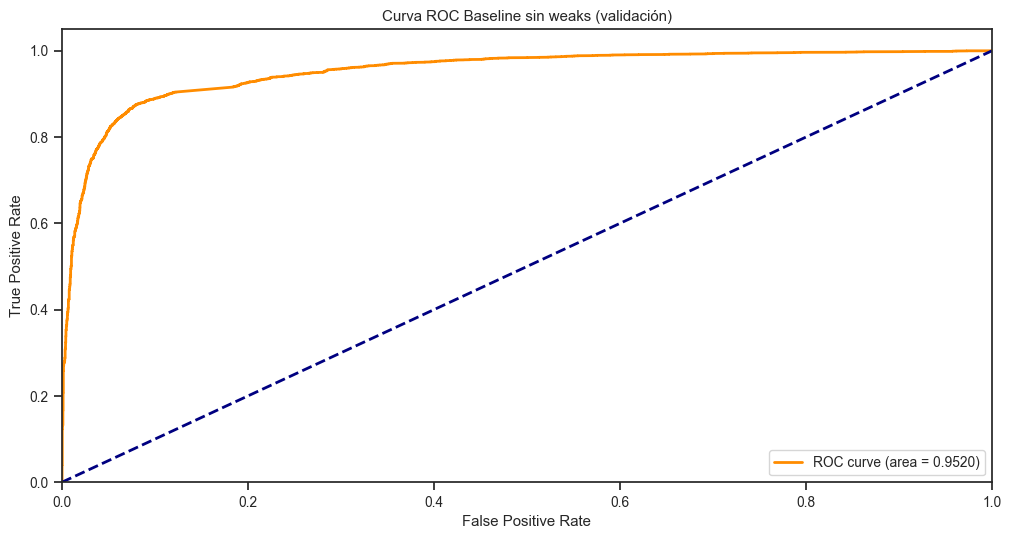

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, prediccion)
titulo = "Curva ROC Baseline sin weaks (validación)"
plot_roc(fpr, tpr, thresholds, titulo)

# Train con Weakly labeled Tweets: TF-IDF Vectorizer, PCA, Standard Scaler y Regresión Logística

## Preprocesamiento de X_train con weakly labeles tweets y X_val

In [ ]:
tw_ingles_portuges_weak_train_tf_idf, tw_ingles_portugues_val_tf_idf = preprocessing_tf_idf_vectorizer_standard_scaler_pca(tw_ingles_portuges_weak_train_df, X_val)

## Regresión Logística

### Búsqueda de hiperparámetros

In [ ]:
logistic_model = LogisticRegression(max_iter = 200, random_state=22)

penalty = ['l1', 'l2']
C = np.logspace(-1, 2, 50)
solver = ['newton-cg', 'lbfgs', 'liblinear']

logistic_hyperparameters = dict(penalty=penalty, C=C, solver=solver)

In [ ]:
rsearch = RandomizedSearchCV(estimator=logistic_model, param_distributions=logistic_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_iter=50, n_jobs=-1)
rsearch.fit(tw_ingles_portuges_weak_train_tf_idf, tw_ingles_portuges_weak_train_target_df)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=200, random_state=22),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.6...
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='roc_auc', verbose=4)

In [ ]:
parametros = rsearch.best_params_
parametros

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.9540954763499939}

### Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = LogisticRegression(**parametros, random_state=22)
modelo.fit(tw_ingles_portuges_weak_train_tf_idf, tw_ingles_portuges_weak_train_target_df)

LogisticRegression(C=0.9540954763499939, penalty='l1', random_state=22,
                   solver='liblinear')

In [ ]:
prediccion = modelo.predict_proba(tw_ingles_portugues_val_tf_idf)[:,1]

In [ ]:
round(roc_auc_score(y_val, prediccion, average='micro'), 4)

0.9301

### Grafico la cruva roc 

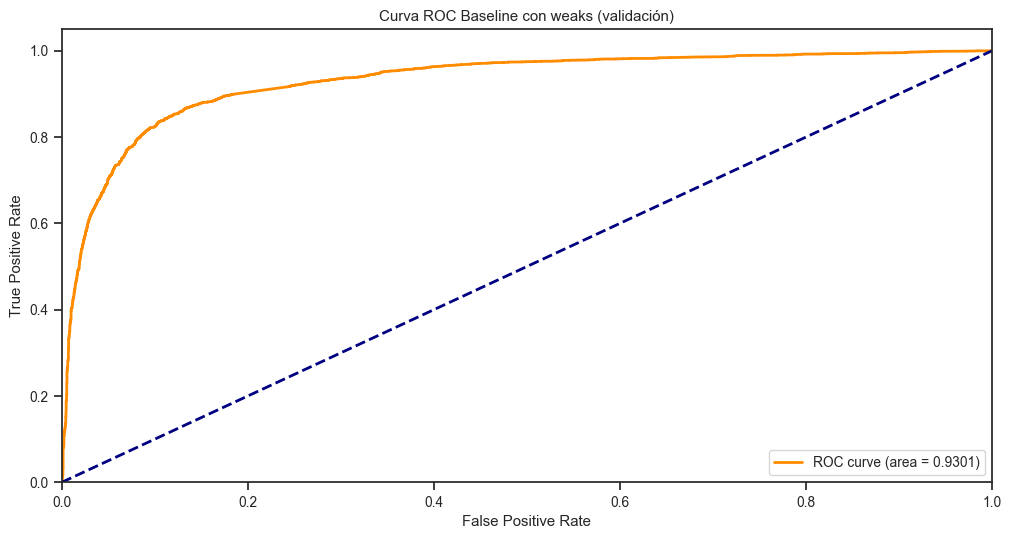

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, prediccion)
titulo = "Curva ROC Baseline con weaks (validación)"
plot_roc(fpr, tpr, thresholds, titulo)

# ¿Cómo conviene usar los débilmente clasificados?

Para el baseline, es mejor no usar los débilmente clasificados